In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import torch

import time
import datetime

import warnings

__ROOT_PATH = os.path.abspath('../')
sys.path.append(__ROOT_PATH)

from vol_surface_manager.kap_constants import *
from vol_surface_manager.kap_parse_args import parse_args
from vol_surface_manager.kap_logger import acquire_logger
from vol_surface_manager.kap_utils import compute_l1_loss, compute_l2_loss, compute_smile_l1_loss, \
    compute_smile_l2_loss, fit_param_curve
from vol_surface_manager.kap_data_loader import load_data_from_config, \
    save_coef_data_from_config, save_selection_data_from_config
from vol_surface_manager.kap_data_loader import load_selection_data, load_coef_data, load_irs_data, load_dividend_data
from vol_surface_manager.kap_main_data import daily_coefs_to_coef_data, daily_train_data_to_selection_data
from vol_surface_manager.kap_main_data import acquire_daily_coefs, coef_data_to_daily_coefs, \
    selection_data_to_daily_train_data
from vol_surface_manager.kap_main_data import irs_data_to_daily_irs, dividend_data_to_daily_dividend
from vol_surface_manager.kap_main_data import acquire_daily_param_data, acquire_daily_train_data, acquire_daily_smile_data
from vol_surface_manager.kap_main_data import select_daily_train_data, plot_daily_param_data, \
    plot_daily_train_data, plot_daily_smile_data
from vol_surface_manager.kap_vol_surface import create_vol_surface_at_day, plot_vol_surface

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from IPython.display import display, HTML, clear_output

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', family = 'serif')

#tableau 정의

# These are the "Tableau 20" colors as RGB.
tableau10=[(31,119,180),(255,158,74),(103,191,92),(240,39,40),(176,139,201),
           (168,120,110),(237,151,202),(162,162,162),(205,204,93),(109,204,218)]
for i in range(len(tableau10)):
    r,g,b=tableau10[i]
    tableau10[i]=(r/255.,g/255.,b/255.)
plt.style.use(['fast'])

# ignore by message
warnings.filterwarnings("ignore", message="overflow encountered in square")
warnings.filterwarnings("ignore", message="overflow encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in log")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")
warnings.filterwarnings("ignore", message="invalid value encountered in less_equal")
warnings.filterwarnings("ignore", message="divide by zero encountered in less_equal")
warnings.filterwarnings("ignore", message="invalid value encountered in greater")
warnings.filterwarnings("ignore", message="divide by zero encountered in greater")
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="divide by zero encountered in sqrt")


#font_name = fm.FontProperties(fname=FONT_PATH).get_name()
#matplotlib.rc('font', family = font_name)
register_matplotlib_converters()
matplotlib.rcParams['figure.facecolor'] = 'w'

In [191]:
for idata, DATA_TYPE in enumerate(["Kospi200", "S&P500"]):
#for idata, DATA_TYPE in enumerate(["Kospi200", "Kospi200"]):
    #RESULT_BASE_DIR = "../results/results_test"
    #RESULT_BASE_DIR = "../results/results_transformer"
    #RESULT_BASE_DIR = "../results/results_transformer_single"
    #RESULT_BASE_DIR = "../results/results_mlp"
    #RESULT_BASE_DIR = "../results/results_mlp_single"
    #RESULT_BASE_DIR = "../results/results_cnn"
    #RESULT_BASE_DIR = "../results/results_cnn_single"
    #RESULT_BASE_DIR = "../results/results_svm"
    RESULT_BASE_DIR = "../results/results_svm_single"
    SAVE_FIGURES = True

    # 0. Parsing arguments
    sys.argv = ["kap_runme_vol_surface.py",
                "--DATA_TYPE=%s" % DATA_TYPE,
                "--RESULT_BASE_DIR=%s" % RESULT_BASE_DIR,
                "--SAVE_FIGURES=%s" % str(SAVE_FIGURES)]
    _config = parse_args()

    if idata == 0:
        config_kospi200 = _config
    else:
        assert(idata == 1)
        config_snp500 = _config

logger = acquire_logger(config_kospi200)
#FONT_BASE_DIR = os.path.join(config.DATA_BASE_DIR, 'font')
#assert(os.path.isdir(FONT_BASE_DIR))
#FONT_PATH = os.path.join(FONT_BASE_DIR, 'NanumGothicBold.ttf')
#assert(os.path.isfile(FONT_PATH))

In [192]:
# 2. Acquiring market data
for config in [config_kospi200, config_snp500]:
    _market_data, _raw_param_data, _coef_data, _all_days, _coef_days, _market_days = load_data_from_config(
        config, logger, mode='eval', acquire_market_data=True)
    if config.DATA_TYPE == 'Kospi200':
        market_data_kospi200 = (_market_data, _raw_param_data, _coef_data, _all_days, _coef_days, _market_days)
    else:
        assert(config.DATA_TYPE == 'S&P500')
        market_data_snp500 = (_market_data, _raw_param_data, _coef_data, _all_days, _coef_days, _market_days)
logger.info('Market data are loaded.')

    INFO - Market data are loaded.


In [193]:
# 3. Acquiring IRS data and selection data
for config, (_market_data, _raw_param_data, _coef_data, _all_days, _coef_days, _market_days) in [
    (config_kospi200, market_data_kospi200), (config_snp500, market_data_snp500)]:

    # Acquire IRS data and Dividend data
    irs_path = os.path.join(config.DATA_BASE_DIR, config.DATA_TYPE + '_IRS_Div' + '.xlsx')
    _irs_data = load_irs_data(irs_path)
    _irs_days = sorted([day for day in _irs_data.index])
    _dividend_data = load_dividend_data(irs_path)
    _dividend_days = sorted([day for day in _dividend_data.index])

    # Acquire selection data
    selection_path = os.path.join(config.RESULT_BASE_DIR, config.DATA_TYPE + '_coef_Data_Selection' + '.xlsx')
    pred_coef_path = os.path.join(config.RESULT_BASE_DIR, config.DATA_TYPE + '_coef_Data_Prediction' + '.xlsx')
    _alpha_selection_data, _rho_selection_data, _nu_selection_data = load_selection_data(selection_path)
    _pred_coef_data = load_coef_data(pred_coef_path)
    _test_days = [day for day in _pred_coef_data.index]

    #display(_dividend_data)
    print(len([day for day in _test_days if (day in _irs_days and day in _dividend_days)]))
    print([day for day in _test_days if (day in _irs_days and day in _dividend_days)])
    #assert(all(day in _irs_days for day in _test_days))
    #assert(0==1)

    if config.DATA_TYPE == 'Kospi200':
        all_data_kospi200 = (_market_data, _raw_param_data, _coef_data, _all_days, _coef_days, _market_days,
                             _irs_data, _irs_days, _dividend_data, _dividend_days,
                             _alpha_selection_data, _rho_selection_data, _nu_selection_data, _pred_coef_data,
                             _test_days)
    else:
        assert(config.DATA_TYPE == 'S&P500')
        all_data_snp500 = (_market_data, _raw_param_data, _coef_data, _all_days, _coef_days, _market_days,
                           _irs_data, _irs_days, _dividend_data, _dividend_days,
                           _alpha_selection_data, _rho_selection_data, _nu_selection_data, _pred_coef_data,
                           _test_days)
    print('Test days for data %s: %d days.' % (config.DATA_TYPE, len(_test_days)))
    #print(sorted(_test_days))
    #print('')
logger.info('Market data and selection data are loaded.')

63
[Timestamp('2019-01-02 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-08 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-10 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-15 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-17 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-21 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2019-01-23 00:00:00'), Timestamp('2019-01-24 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-01 00:00:00'), Timestamp('2019-02-07 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-11 00:00:00'), Timestamp('2019-02-12 00:00:00'), Timestamp('2019-02-13 00:00:00'), Timestamp('2019-02-14 00:00:00'), Timestamp(

    INFO - Market data and selection data are loaded.


[Timestamp('2019-01-02 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-08 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-10 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-15 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-17 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-21 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2019-01-23 00:00:00'), Timestamp('2019-01-24 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-01 00:00:00'), Timestamp('2019-02-07 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-11 00:00:00'), Timestamp('2019-02-12 00:00:00'), Timestamp('2019-02-13 00:00:00'), Timestamp('2019-02-14 00:00:00'), Timestamp('20

In [5]:
def plot_maturity_distribution_result(market_data, raw_param_data, coef_data, all_days, save_path='', plot_result=True):
    all_tenors = []
    for day in all_days:
        all_tenors += (raw_param_data.loc[day]['Tenor'] / float(DAYS_PER_YEAR)).to_numpy().tolist()
    all_tenors = np.array(all_tenors)
    all_tenors_and_points = []
    for day in market_days:
        daily_market_data = market_data.loc[day].set_index('Tenor')
        tenors = sorted(list(set(market_data.loc[day]['Tenor'].to_numpy().tolist())))
        for tenor in tenors:
            #num_points = len(list(set(daily_market_data.loc[[tenor]]['Strike'].to_numpy().tolist())))
            num_points = len(daily_market_data.loc[[tenor]])
            all_tenors_and_points.append([tenor / float(DAYS_PER_YEAR), num_points])
    all_tenors_and_points = np.array(all_tenors_and_points)
    indices = np.argsort(all_tenors_and_points[:, 0])
    all_tenors_and_points = all_tenors_and_points[indices]

    all_tenor_numbers = []
    for day in all_days:
        all_tenor_numbers.append(len(raw_param_data.loc[day]))

    fig = plt.figure(figsize=(22.5, 5))

    fontsize = 18
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('%s, Distribution of Maturity.' % config.DATA_TYPE.replace('&', '\&'), fontsize=fontsize)
    ax.set_xlabel('Maturity (year)', fontsize=fontsize)
    ax.set_ylabel('Distribution', fontsize=fontsize)
    ax.hist(all_tenors, bins=20, density=True)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    ax = fig.add_subplot(1, 3, 1)

    x_bd = np.linspace(0., 3., 21)
    x = (x_bd[:-1] + x_bd[1:]) / 2.
    y = []
    y_err = []
    for ix in range(len(x)):
        sub_indices = np.logical_and(all_tenors_and_points[:, 0] >= x_bd[ix],
                                     all_tenors_and_points[:, 0] < x_bd[ix+1])
        sub_points = all_tenors_and_points[sub_indices, 1]
        y.append(np.mean(sub_points))
        y_err.append(np.std(sub_points))
    y = np.array(y)
    y_err = np.array(y_err)

    #ax.set_title('%s, Maturity distribution.' % config.DATA_TYPE.replace('&', '\&'), fontsize=15)
    ax.set_title('%s, Averaged Number of Options on Maturities.' % config.DATA_TYPE.replace('&', '\&'), fontsize=fontsize)
    ax.set_xlabel('Maturity (year)', fontsize=fontsize)
    ax.set_ylabel('Number of Options', fontsize=fontsize)
    ax.errorbar(x, y, yerr=y_err, fmt='o', color='b', ecolor='r', elinewidth=1.2, capsize=3, capthick=1.2)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    #ax.plot(all_tenors_and_points[:, 0], all_tenors_and_points[:, 1], 'k.')

    ax = fig.add_subplot(1, 3, 2)
    max_num = np.max(all_tenor_numbers)
    min_num = np.min(all_tenor_numbers)
    ax.set_title('%s, Distribution of the Number of Different Maturities.' % config.DATA_TYPE.replace('&', '\&'), fontsize=fontsize)
    ax.set_xlabel('Number of Maturities', fontsize=fontsize)
    ax.set_ylabel('Distribution', fontsize=fontsize)
    ax.hist(all_tenor_numbers, bins=(max_num-min_num+1)*2-1, range=(min_num-0.25, max_num+0.25), density=True)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if plot_result:
        plt.show()

In [6]:
def plot_parameter_curve_result(config, day, yesterday, market_data, raw_param_data, coef_data,
                                save_path='', plot_result=True, parameter='Alpha'):
    daily_param_data = acquire_daily_param_data(
        day, yesterday, market_data, raw_param_data, coef_data, parameter)
    plot_daily_param_data(config, daily_param_data, save_path, plot_result, parameter)

def plot_train_curve_result(config, day, yesterday, market_data, raw_param_data, coef_data,
                            selection_data, save_path='', plot_result=True, parameter='Alpha'):
    daily_param_data = acquire_daily_param_data(
        day, yesterday, market_data, raw_param_data, coef_data, parameter)
    daily_train_data = acquire_daily_train_data(daily_param_data, parameter)
    daily_train_data = selection_data_to_daily_train_data(selection_data, daily_train_data, parameter)
    plot_daily_train_data(config, daily_train_data, save_path, plot_result, parameter)

def plot_parameter_curves_result(config, day, yesterday, market_data, raw_param_data, coef_data,
                                 save_path='', plot_result=True):
    parameters = ['Alpha', 'Rho', 'Nu']
    daily_param_datas = []
    for parameter in parameters:
        daily_param_data = acquire_daily_param_data(
            day, yesterday, market_data, raw_param_data, coef_data, parameter)
        daily_param_datas.append(daily_param_data)
    plot_daily_param_data(config, daily_param_datas, save_path, plot_result, parameters)

def plot_all_point_curves_result(config, day, yesterday, market_data, raw_param_data, coef_data,
                                 save_path='', plot_result=True):
    parameters = ['Alpha', 'Rho', 'Nu']
    daily_train_datas = []
    for parameter in parameters:
        daily_param_data = acquire_daily_param_data(
            day, yesterday, market_data, raw_param_data, coef_data, parameter)
        daily_train_data = acquire_daily_train_data(daily_param_data, parameter)
        day, state, gold_coefs, yesterday_coefs, pred_coefs = daily_train_data
        candidate_is_selected = np.copy(state[:, 3] == 1.)
        candidate_is_selected[:] = True
        daily_train_data = select_daily_train_data(daily_train_data, candidate_is_selected, parameter)
        daily_train_datas.append(daily_train_data)
    plot_daily_train_data(config, daily_train_datas, save_path, plot_result, parameters)

def plot_raw_only_curves_result(config, day, yesterday, market_data, raw_param_data, coef_data,
                                save_path='', plot_result=True):
    parameters = ['Alpha', 'Rho', 'Nu']
    daily_train_datas = []
    for parameter in parameters:
        daily_param_data = acquire_daily_param_data(
            day, yesterday, market_data, raw_param_data, coef_data, parameter)
        daily_train_data = acquire_daily_train_data(daily_param_data, parameter)
        day, state, gold_coefs, yesterday_coefs, pred_coefs = daily_train_data
        candidate_is_selected = np.copy(state[:, 3] == 1.)
        candidate_is_selected[:] = True
        candidate_is_selected[:NUM_STANDARD_TENOR] = False
        daily_train_data = select_daily_train_data(daily_train_data, candidate_is_selected, parameter)
        daily_train_datas.append(daily_train_data)
    plot_daily_train_data(config, daily_train_datas, save_path, plot_result, parameters)

def plot_train_curves_result(config, day, yesterday, market_data, raw_param_data, coef_data,
                             alpha_selection_data, rho_selection_data, nu_selection_data,
                             save_path='', plot_result=True):
    parameters = ['Alpha', 'Rho', 'Nu']
    selection_datas = [alpha_selection_data, rho_selection_data, nu_selection_data]
    daily_train_datas = []
    for parameter, selection_data in zip(parameters, selection_datas):
        daily_param_data = acquire_daily_param_data(
            day, yesterday, market_data, raw_param_data, coef_data, parameter)
        daily_train_data = acquire_daily_train_data(daily_param_data, parameter)
        daily_train_data = selection_data_to_daily_train_data(selection_data, daily_train_data, parameter)
        daily_train_datas.append(daily_train_data)
    plot_daily_train_data(config, daily_train_datas, save_path, plot_result, parameters)

def plot_smile_curve_result(config, day, yesterday, market_data, raw_param_data, coef_data, pred_coef_data,
                            save_path='', plot_result=True, plot_tenor=None):
    for parameter in ['Alpha', 'Rho', 'Nu']:
        daily_param_data = acquire_daily_param_data(
            day, yesterday, market_data, raw_param_data, coef_data, parameter)
        if parameter == 'Alpha':
            daily_alpha_data = daily_param_data
        elif parameter == 'Rho':
            daily_rho_data = daily_param_data
        else:
            assert(parameter == 'Nu')
            daily_nu_data = daily_param_data
    pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs = coef_data_to_daily_coefs(day, pred_coef_data)
    daily_smile_data = acquire_daily_smile_data(day, market_data, raw_param_data, coef_data)
    if daily_smile_data is not None:
        plot_daily_smile_data(config, daily_smile_data, daily_alpha_data, daily_rho_data, daily_nu_data,
                              pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs, save_path, plot_result, plot_tenor)

def plot_vol_surface_result(config, day, yesterday, market_data, coef_data, pred_coef_data, irs_data, dividend_data,
                            save_path='', plot_result=True, surface_type='gold'):
    gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs = coef_data_to_daily_coefs(day, coef_data)
    yesterday_alpha_coefs, yesterday_rho_coefs, yesterday_nu_coefs = coef_data_to_daily_coefs(yesterday, coef_data)
    pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs = coef_data_to_daily_coefs(day, pred_coef_data)
    irs = irs_data_to_daily_irs(day, irs_data)
    dividend = dividend_data_to_daily_dividend(day, dividend_data, market_data)
    plot_vol_surface(config, day, pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs,
                     yesterday_alpha_coefs, yesterday_rho_coefs, yesterday_nu_coefs,
                     gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                     save_path, plot_result, surface_type=surface_type, irs=irs, dividend=dividend)

def compute_loss_result(day, yesterday, coef_data, pred_coef_data, parameter='Alpha', type='L1'):
    gold_coefs = acquire_daily_coefs(day, coef_data, parameter)
    yesterday_coefs = acquire_daily_coefs(yesterday, coef_data, parameter)
    pred_coefs = acquire_daily_coefs(day, pred_coef_data, parameter)
    curve_tenors = np.linspace(0., 3., num=37)[1:]
    if type == 'L1':
        pred_loss = compute_l1_loss(pred_coefs, gold_coefs, curve_tenors, parameter)
        yesterday_loss = compute_l1_loss(yesterday_coefs, gold_coefs, curve_tenors, parameter)
    else:
        assert(type == 'L2')
        pred_loss = compute_l2_loss(pred_coefs, gold_coefs, curve_tenors, parameter)
        yesterday_loss = compute_l2_loss(yesterday_coefs, gold_coefs, curve_tenors, parameter)
    return pred_loss, yesterday_loss

def compute_benchmark_loss_result(day, yesterday, market_data, raw_param_data, coef_data,
                                  parameter='Alpha', type='L1'):
    daily_param_data = acquire_daily_param_data(
        day, yesterday, market_data, raw_param_data, coef_data, parameter)
    daily_train_data = acquire_daily_train_data(daily_param_data, parameter)

    day, state, gold_coefs, yesterday_coefs, pred_coefs = daily_train_data
    # update train data from current selection.
    candidate_tenors = state[:, 0]
    candidate_params = state[:, 1]
    candidate_is_selected = np.copy(state[:, 3] == 1.)
    # 1. Using all points
    candidate_is_selected[:] = True
    all_point_coefs = fit_param_curve(candidate_params[candidate_is_selected],
                                      candidate_tenors[candidate_is_selected],
                                      yesterday_coefs, parameter)
    # 2. Using raw points
    candidate_is_selected[:NUM_STANDARD_TENOR] = False
    raw_only_coefs = fit_param_curve(candidate_params[candidate_is_selected],
                                     candidate_tenors[candidate_is_selected],
                                     yesterday_coefs, parameter)
    curve_tenors = np.linspace(0., 3., num=37)[1:]
    if type == 'L1':
        all_point_loss = compute_l1_loss(all_point_coefs, gold_coefs, curve_tenors, parameter)
        raw_only_loss = compute_l1_loss(raw_only_coefs, gold_coefs, curve_tenors, parameter)
    else:
        assert(type == 'L2')
        all_point_loss = compute_l2_loss(all_point_coefs, gold_coefs, curve_tenors, parameter)
        raw_only_loss = compute_l2_loss(raw_only_coefs, gold_coefs, curve_tenors, parameter)
    return all_point_loss, raw_only_loss

def compute_smile_loss_result(day, yesterday, coef_data, pred_coef_data, t, m_min, m_max, type='L1'):
    gold_alpha_coefs = acquire_daily_coefs(day, coef_data, 'Alpha')
    gold_rho_coefs = acquire_daily_coefs(day, coef_data, 'Rho')
    gold_nu_coefs = acquire_daily_coefs(day, coef_data, 'Nu')
    yesterday_alpha_coefs = acquire_daily_coefs(yesterday, coef_data, 'Alpha')
    yesterday_rho_coefs = acquire_daily_coefs(yesterday, coef_data, 'Rho')
    yesterday_nu_coefs = acquire_daily_coefs(yesterday, coef_data, 'Nu')
    pred_alpha_coefs = acquire_daily_coefs(day, pred_coef_data, 'Alpha')
    pred_rho_coefs = acquire_daily_coefs(day, pred_coef_data, 'Rho')
    pred_nu_coefs = acquire_daily_coefs(day, pred_coef_data, 'Nu')
    if type == 'L1':
        pred_smile_loss = compute_smile_l1_loss(pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs,
                                                gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                t, m_min, m_max)
        yesterday_smile_loss = compute_smile_l1_loss(yesterday_alpha_coefs, yesterday_rho_coefs, yesterday_nu_coefs,
                                                     gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                     t, m_min, m_max)
    else:
        assert(type == 'L2')
        pred_smile_loss = compute_smile_l2_loss(pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs,
                                                gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                t, m_min, m_max)
        yesterday_smile_loss = compute_smile_l2_loss(yesterday_alpha_coefs, yesterday_rho_coefs, yesterday_nu_coefs,
                                                     gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                     t, m_min, m_max)
    return pred_smile_loss, yesterday_smile_loss

def compute_benchmark_smile_loss_result(day, yesterday, market_data, raw_param_data, coef_data, t, m_min, m_max, type='L1'):
    for parameter in ['Alpha', 'Rho', 'Nu']:
        daily_param_data = acquire_daily_param_data(
            day, yesterday, market_data, raw_param_data, coef_data, parameter)
        daily_train_data = acquire_daily_train_data(daily_param_data, parameter)

        day, state, gold_coefs, yesterday_coefs, pred_coefs = daily_train_data
        # update train data from current selection.
        candidate_tenors = state[:, 0]
        candidate_params = state[:, 1]
        candidate_is_selected = np.copy(state[:, 3] == 1.)

        # 1. Using all points
        candidate_is_selected[:] = True
        all_point_coefs = fit_param_curve(candidate_params[candidate_is_selected],
                                          candidate_tenors[candidate_is_selected],
                                          yesterday_coefs, parameter)
        # 2. Using raw points
        candidate_is_selected[:NUM_STANDARD_TENOR] = False
        raw_only_coefs = fit_param_curve(candidate_params[candidate_is_selected],
                                         candidate_tenors[candidate_is_selected],
                                         yesterday_coefs, parameter)
        if parameter == 'Alpha':
            gold_alpha_coefs = gold_coefs
            all_point_alpha_coefs = all_point_coefs
            raw_only_alpha_coefs = raw_only_coefs
        elif parameter == 'Rho':
            gold_rho_coefs = gold_coefs
            all_point_rho_coefs = all_point_coefs
            raw_only_rho_coefs = raw_only_coefs
        else:
            assert(parameter == 'Nu')
            gold_nu_coefs = gold_coefs
            all_point_nu_coefs = all_point_coefs
            raw_only_nu_coefs = raw_only_coefs
    if type == 'L1':
        all_point_smile_loss = compute_smile_l1_loss(all_point_alpha_coefs, all_point_rho_coefs, all_point_nu_coefs,
                                                     gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                     t, m_min, m_max)
        raw_only_smile_loss = compute_smile_l1_loss(raw_only_alpha_coefs, raw_only_rho_coefs, raw_only_nu_coefs,
                                                    gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                    t, m_min, m_max)
    else:
        assert(type == 'L2')
        all_point_smile_loss = compute_smile_l2_loss(all_point_alpha_coefs, all_point_rho_coefs, all_point_nu_coefs,
                                                     gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                     t, m_min, m_max)
        raw_only_smile_loss = compute_smile_l2_loss(raw_only_alpha_coefs, raw_only_rho_coefs, raw_only_nu_coefs,
                                                    gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                                    t, m_min, m_max)
    return all_point_smile_loss, raw_only_smile_loss

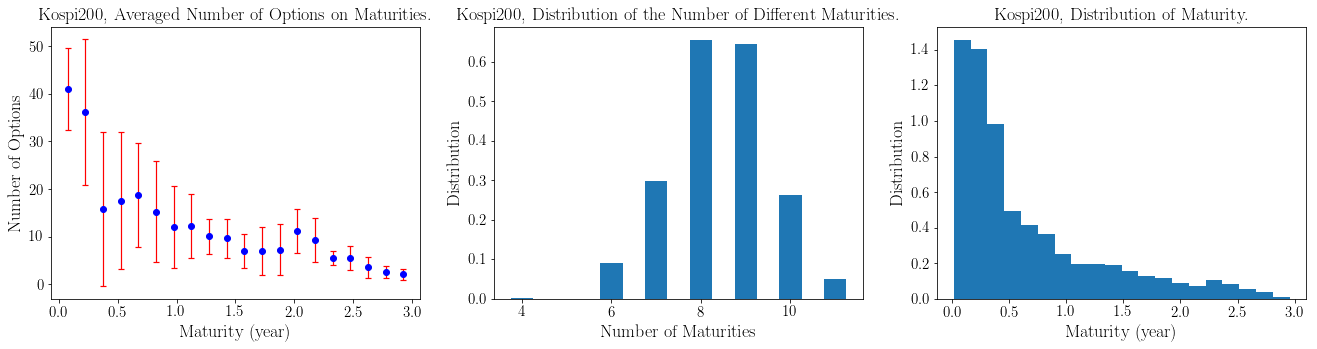

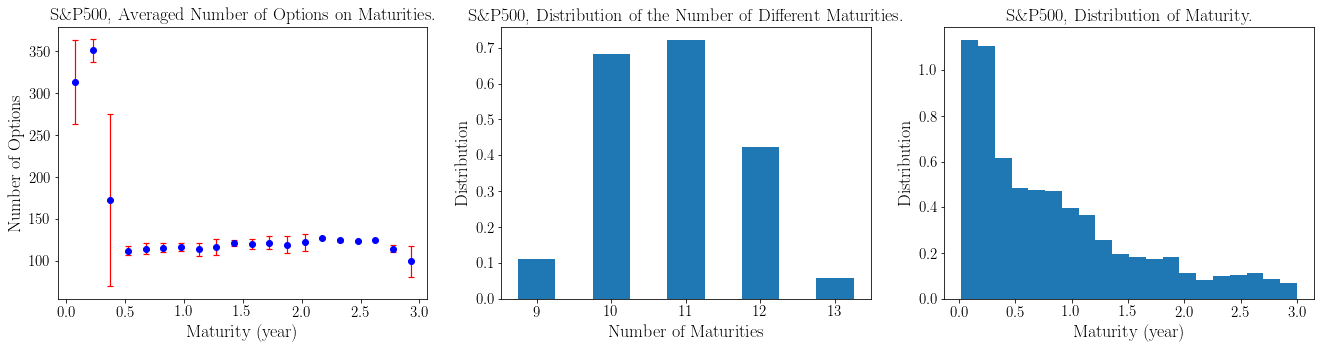

In [9]:
for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    if config.DATA_TYPE == "Kospi200":
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/Kospi200_maturity_distribution.pdf')
    else:
        assert(config.DATA_TYPE == "S&P500")
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/SnP500_maturity_distribution.pdf')
    plot_result = True

    plot_maturity_distribution_result(market_data, raw_param_data, coef_data, all_days, save_path, plot_result)

In [29]:
print(test_days[58])
cnt = 0
for iday, day in enumerate(test_days[53:63]):
    if day not in irs_days or day not in dividend_days:
        cnt += 1
print(cnt)

2019-03-22 00:00:00
0


In [12]:
from vol_surface_manager.kap_utils import compute_irs, monte_carlo, local_monte_carlo, smile, \
    vol_surface, local_vol_surface, _alpha, _rho, _nu

(market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
 irs_data, irs_days, dividend_data, dividend_days,
 alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
 test_days
) = all_data_kospi200
#) = all_data_snp500

results = []
losses = []
start_time = time.time()
for iday, day in enumerate(test_days[53:63]):
    if day not in irs_days or day not in dividend_days:
        continue
    daily_market_data = market_data.loc[day].set_index('Tenor', drop=False)

    gold_alpha_coefs = acquire_daily_coefs(day, coef_data, 'Alpha')
    gold_rho_coefs = acquire_daily_coefs(day, coef_data, 'Rho')
    gold_nu_coefs = acquire_daily_coefs(day, coef_data, 'Nu')
    pred_alpha_coefs = acquire_daily_coefs(day, pred_coef_data, 'Alpha')
    pred_rho_coefs = acquire_daily_coefs(day, pred_coef_data, 'Rho')
    pred_nu_coefs = acquire_daily_coefs(day, pred_coef_data, 'Nu')
    irs = irs_data_to_daily_irs(day, irs_data)
    dividend = dividend_data_to_daily_dividend(day, dividend_data, market_data)

    spot = float(daily_market_data['SpotPrice'].iloc[0])

    moneynesses = np.array([-0.2, -0.15, -0.1, -0.05, 0., 0.05, 0.1])
    positions = np.array(['P', 'P', 'P', 'P', 'P', 'C', 'C'])
    tenors = np.array([3., 6., 12., 24.]) / 12.
    num_samples = np.array([4000000, 2000000, 1000000, 1000000])
    #moneynesses = np.array([-0.1])
    #tenors = np.array([1.]) / 12.

    losses_day = []
    for itenor, tenor in enumerate(tenors):
        for imoneyness, moneyness in enumerate(moneynesses):
            num_sample = num_samples[itenor]
            position = positions[imoneyness]
            #num_sample = 1000000 if tenor < 0.75 else 1000000
            #position = 'P' if moneyness <= 0 else 'C'
            C_gold = local_monte_carlo(tenor, moneyness, position,
                                       gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                                       irs=irs, dividend=dividend, num_sample=num_sample)
            C_pred = local_monte_carlo(tenor, moneyness, position,
                                       pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs,
                                       irs=irs, dividend=dividend, num_sample=num_sample)

            s = (f'{day.strftime("%Y-%m-%d"):s}    {tenor:.5f}    {moneyness: 2.2f}' +
                 f'    {np.exp(C_gold):.10f}    {np.exp(C_pred):.10f}' +
                 f'    {spot:4.0f}    {spot * np.exp(C_gold):.10f}    {spot * np.exp(C_pred):.10f}' +
                 f'    {(np.exp(C_pred)-np.exp(C_gold))/np.exp(C_gold)*100:2.5f}%   Elapsed: {time.time()-start_time:.2f}')
            print(s)
            results.append((day, tenor, moneyness, spot, C_gold, C_pred))
            losses_day.append((np.exp(C_pred)-np.exp(C_gold))/np.exp(C_gold)*100.)
    losses.append(losses_day)
losses = np.array(losses)

#print(results)
#print(losses)
print(np.fabs(losses).mean(axis=0))

2019-03-15    0.25000    -0.20    0.0010285378    0.0009074784     280    0.2878568775    0.2539759895    -11.77005%   Elapsed: 173.99
2019-03-15    0.25000    -0.15    0.0021083563    0.0019218387     280    0.5900656812    0.5378649959    -8.84659%   Elapsed: 346.96
2019-03-15    0.25000    -0.10    0.0045695851    0.0043517673     280    1.2788897905    1.2179291045    -4.76669%   Elapsed: 520.78
2019-03-15    0.25000    -0.05    0.0107103005    0.0104526410     280    2.9974918025    2.9253806239    -2.40572%   Elapsed: 693.18
2019-03-15    0.25000     0.00    0.0258693779    0.0258435934     280    7.2400627910    7.2328464710    -0.09967%   Elapsed: 864.56
2019-03-15    0.25000     0.05    0.0088087329    0.0089644672     280    2.4653000727    2.5088854460    1.76795%   Elapsed: 1035.93
2019-03-15    0.25000     0.10    0.0022094422    0.0023295513     280    0.6183565760    0.6519715121    5.43617%   Elapsed: 1207.94
2019-03-15    0.50000    -0.20    0.0041069898    0.003511877

In [60]:
from vol_surface_manager.kap_utils import compute_irs, local_vix

(market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
 irs_data, irs_days, dividend_data, dividend_days,
 alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
 test_days
) = all_data_kospi200
#) = all_data_snp500

results = []
losses = []
start_time = time.time()
for iday, day in enumerate(test_days[53:63]):
    if day not in irs_days or day not in dividend_days:
        continue
    daily_market_data = market_data.loc[day].set_index('Tenor', drop=False)

    gold_alpha_coefs = acquire_daily_coefs(day, coef_data, 'Alpha')
    gold_rho_coefs = acquire_daily_coefs(day, coef_data, 'Rho')
    gold_nu_coefs = acquire_daily_coefs(day, coef_data, 'Nu')
    pred_alpha_coefs = acquire_daily_coefs(day, pred_coef_data, 'Alpha')
    pred_rho_coefs = acquire_daily_coefs(day, pred_coef_data, 'Rho')
    pred_nu_coefs = acquire_daily_coefs(day, pred_coef_data, 'Nu')
    irs = irs_data_to_daily_irs(day, irs_data)
    dividend = dividend_data_to_daily_dividend(day, dividend_data, market_data)

    spot = float(daily_market_data['SpotPrice'].iloc[0])

    tenors = np.array([3., 6., 12., 24.]) / 12.
    num_samples = np.array([4000000, 2000000, 1000000, 1000000])
    #moneynesses = np.array([-0.1])
    #tenors = np.array([1.]) / 12.

    losses_day = []
    for itenor, tenor in enumerate(tenors):
        num_sample = num_samples[itenor]
        #num_sample = 1000000 if tenor < 0.75 else 1000000
        V_gold = local_vix(tenor,
                           gold_alpha_coefs, gold_rho_coefs, gold_nu_coefs,
                           irs=irs, dividend=dividend, num_sample=num_sample)
        V_pred = local_vix(tenor,
                           pred_alpha_coefs, pred_rho_coefs, pred_nu_coefs,
                           irs=irs, dividend=dividend, num_sample=num_sample)

        s = (f'{day.strftime("%Y-%m-%d"):s}    {tenor:.5f}' +
             f'    {V_gold:.10f}    {V_pred:.10f}' +
             f'    {(V_pred-V_gold)/V_gold*100.:2.5f}%   Elapsed: {time.time()-start_time:.2f}')
        print(s)
        results.append((day, tenor, spot, V_gold, V_pred))
        losses_day.append((V_pred-V_gold)/V_gold*100.)
    losses.append(losses_day)
losses = np.array(losses)

#print(results)
#print(losses)
print(np.fabs(losses).mean(axis=0))

2019-03-15    0.25000    14.9494525141    14.8248144509    -0.83373%   Elapsed: 174.90
2019-03-15    0.50000    16.1131831171    15.5579537325    -3.44581%   Elapsed: 347.82
2019-03-15    1.00000    17.2072085565    16.4539214565    -4.37774%   Elapsed: 516.10
2019-03-15    2.00000    17.4582413977    17.1028296876    -2.03578%   Elapsed: 844.12
2019-03-18    0.25000    14.2776093114    14.8215310685    3.80961%   Elapsed: 1016.83
2019-03-18    0.50000    15.5680295701    16.0171145026    2.88466%   Elapsed: 1189.78
2019-03-18    1.00000    16.8668219114    17.1677041349    1.78387%   Elapsed: 1356.26
2019-03-18    2.00000    17.2204952423    17.5034618450    1.64320%   Elapsed: 1686.22
2019-03-19    0.25000    14.4832515235    14.0557013915    -2.95203%   Elapsed: 1860.75
2019-03-19    0.50000    15.4848392862    15.3982217025    -0.55937%   Elapsed: 2033.80
2019-03-19    1.00000    16.6468634744    16.7711660684    0.74670%   Elapsed: 2199.85
2019-03-19    2.00000    17.1250964552   

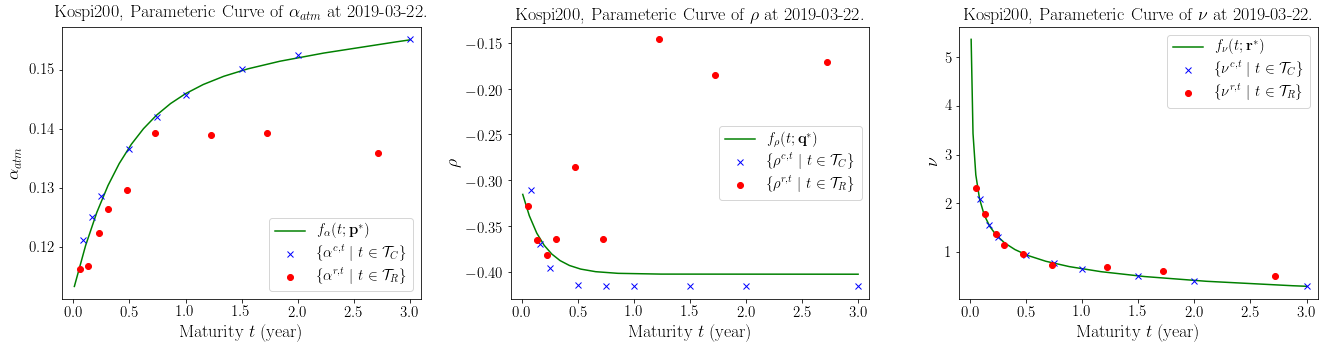

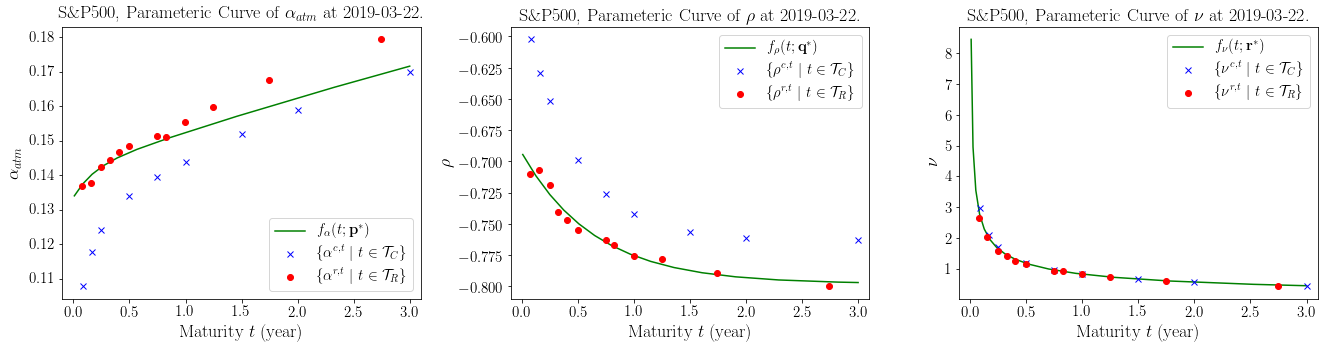

In [12]:
for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    test_day = base_test_day
    if config.DATA_TYPE == "Kospi200":
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/Kospi200_param.pdf')
    else:
        assert(config.DATA_TYPE == "S&P500")
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/SnP500_param.pdf')
    plot_result = True

    day_index = all_days.index(test_day)
    assert(day_index > 0)
    test_yesterday = all_days[day_index-1]

    plot_parameter_curves_result(config, test_day, test_yesterday, market_data, raw_param_data, coef_data,
                                 save_path, plot_result)

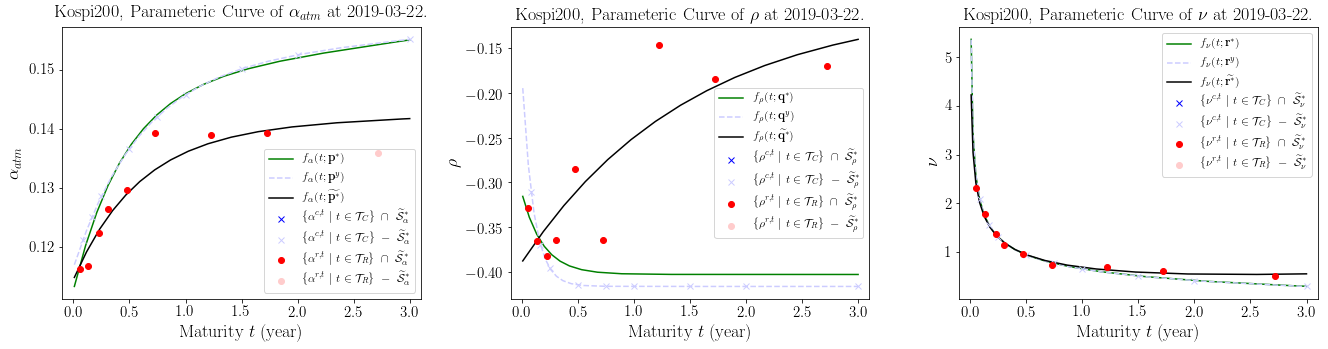

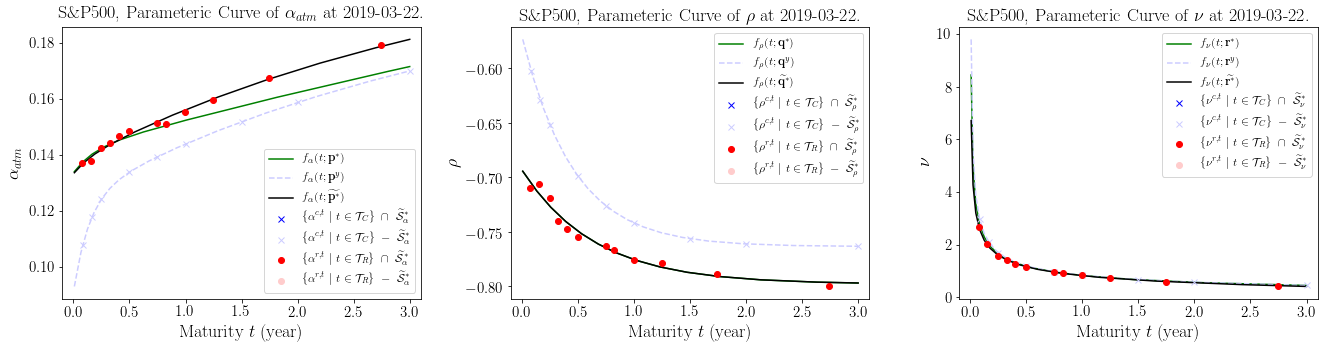

In [14]:
for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    test_day = base_test_day
    if config.DATA_TYPE == "Kospi200":
        #save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/Kospi200_all_point.pdf')
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/Kospi200_raw_only.pdf')
    else:
        assert(config.DATA_TYPE == "S&P500")
        #save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/SnP500_all_point.pdf')
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/SnP500_raw_only.pdf')
    plot_result = True

    day_index = all_days.index(test_day)
    assert(day_index > 0)
    test_yesterday = all_days[day_index-1]

    #plot_all_point_curves_result(config, test_day, test_yesterday, market_data, raw_param_data, coef_data,
    #                             save_path, plot_result)
    plot_raw_only_curves_result(config, test_day, test_yesterday, market_data, raw_param_data, coef_data,
                                save_path, plot_result)


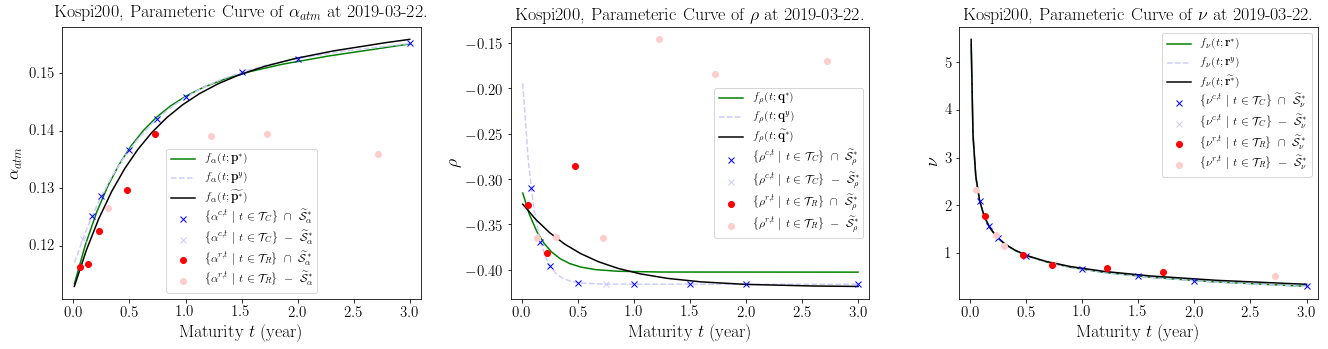

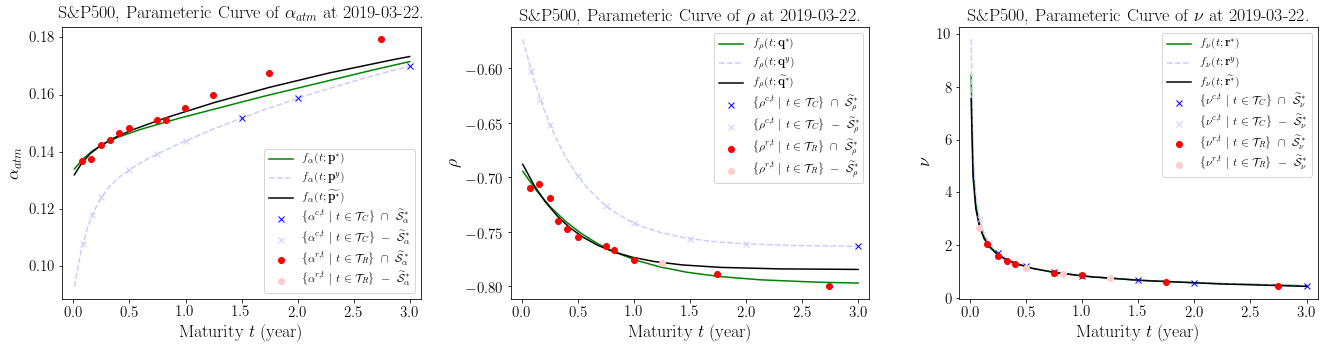

In [10]:
for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    test_day = base_test_day
    if config.DATA_TYPE == "Kospi200":
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/Kospi200_train.pdf')
    else:
        assert(config.DATA_TYPE == "S&P500")
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/SnP500_train.pdf')
    plot_result = True

    day_index = all_days.index(test_day)
    assert(day_index > 0)
    test_yesterday = all_days[day_index-1]

    plot_train_curves_result(config, test_day, test_yesterday, market_data, raw_param_data, coef_data,
                             alpha_selection_data, rho_selection_data, nu_selection_data,
                             save_path, plot_result)

774


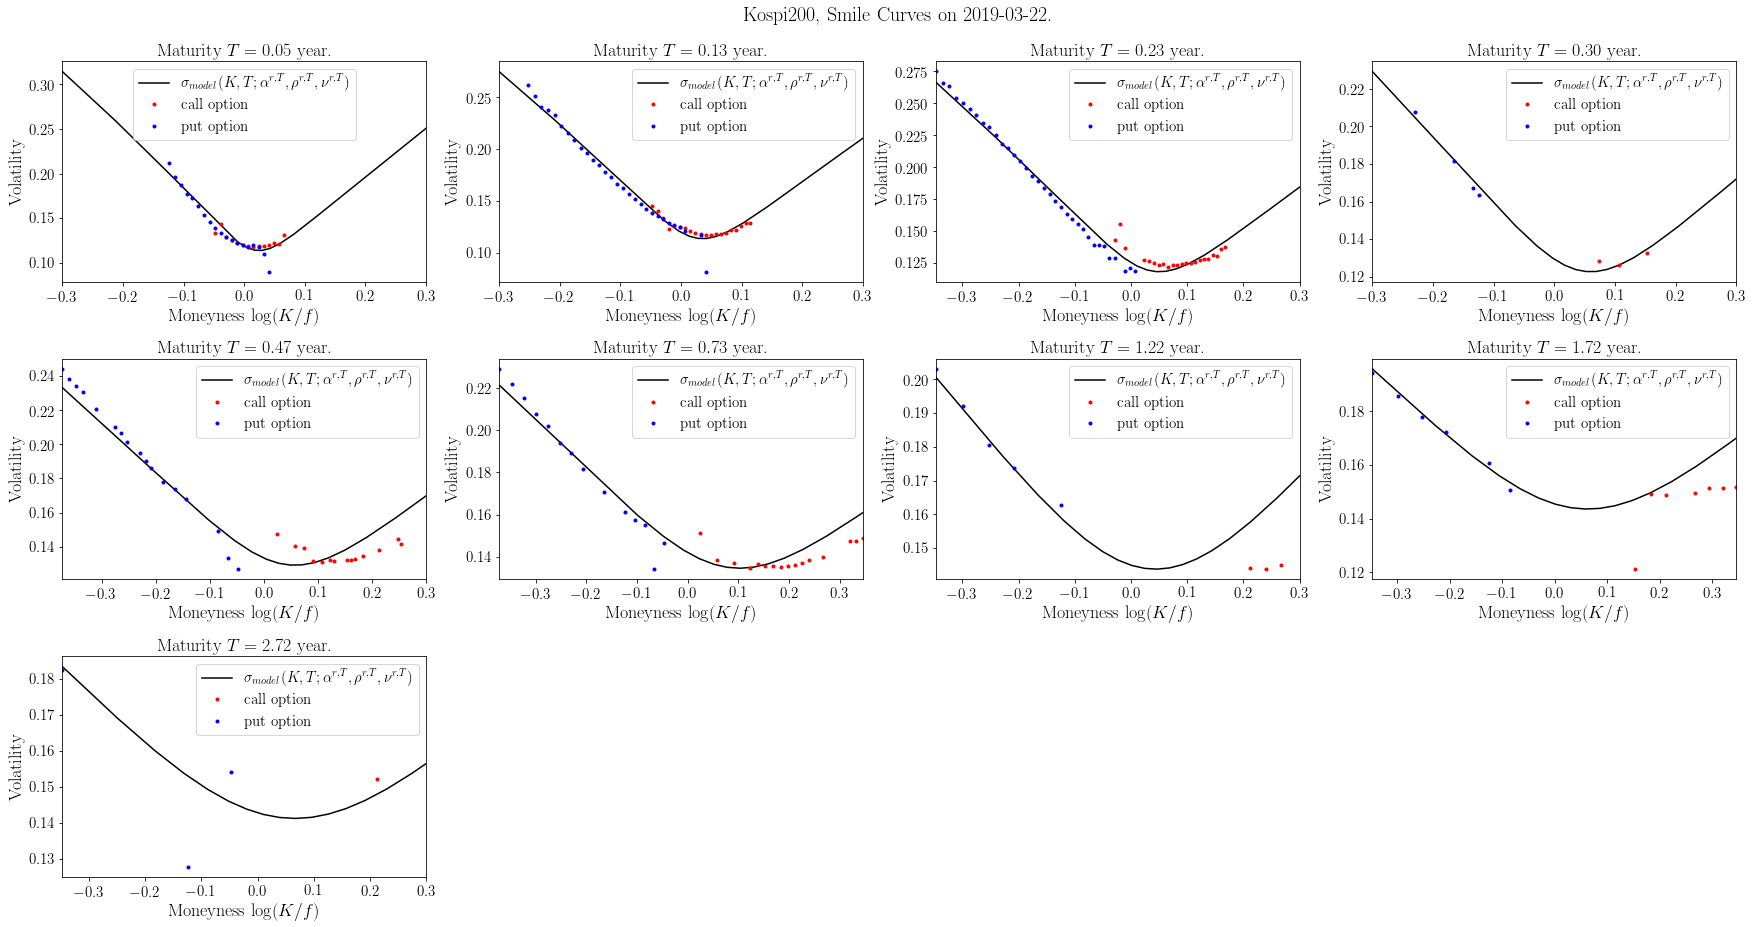

774


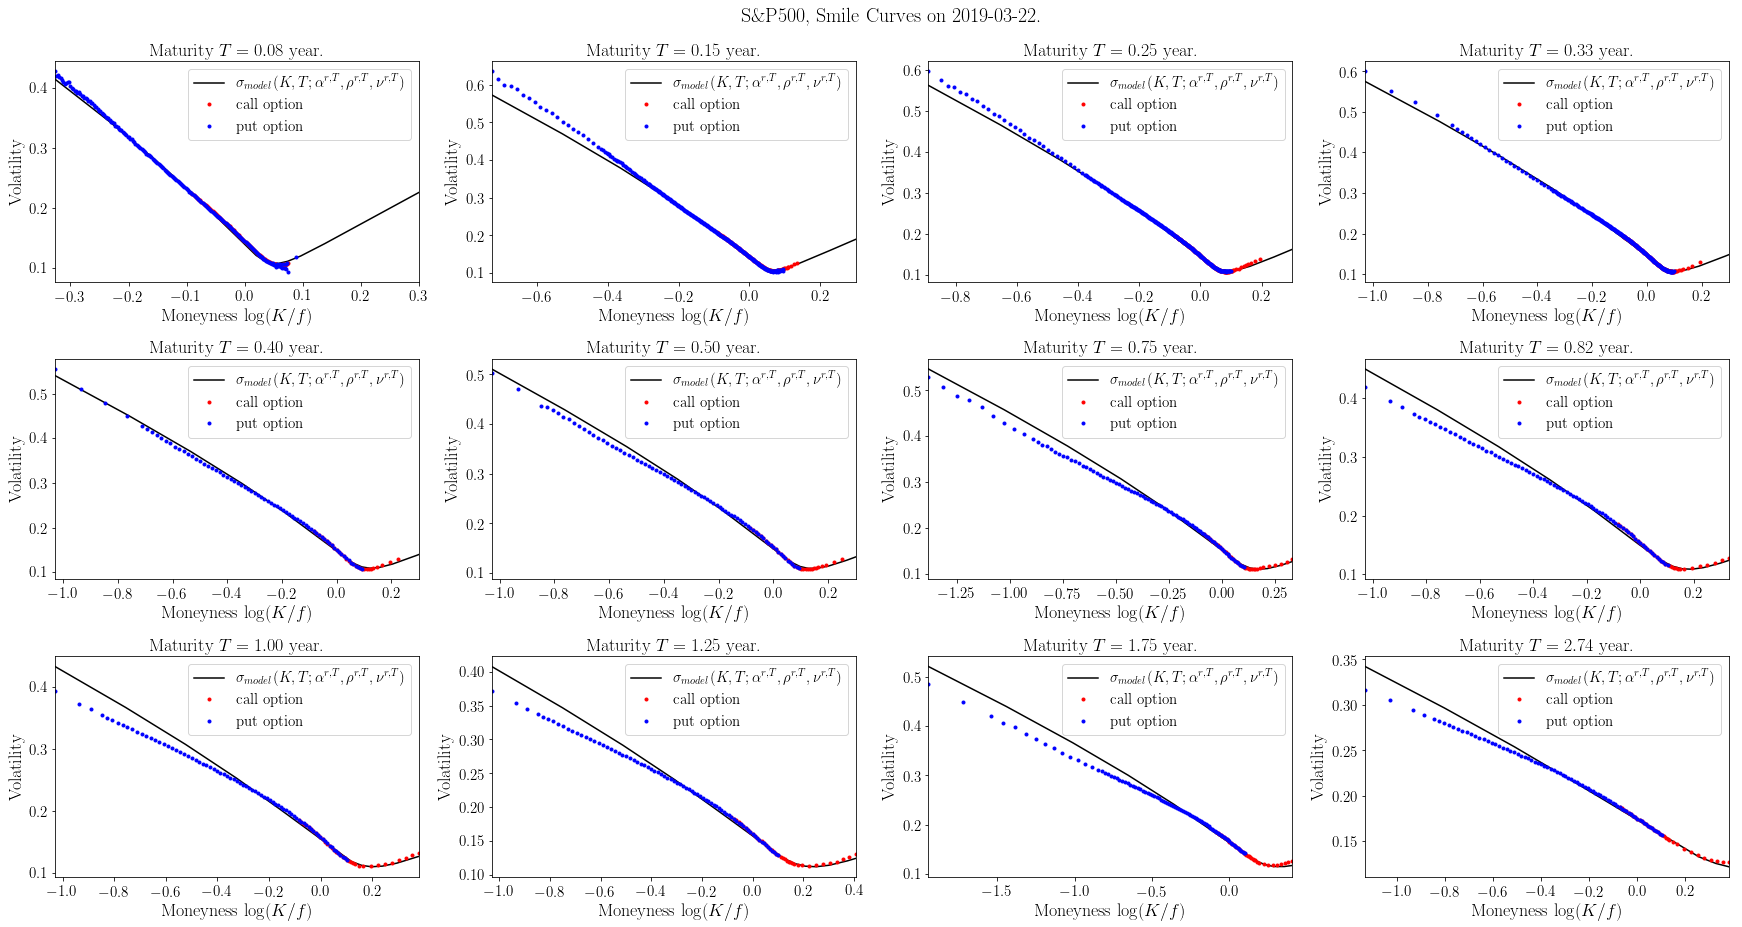

In [18]:
for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    test_day = base_test_day
    plot_result = True
    #plot_tenor = 80
    plot_tenor = None

    day_index = all_days.index(test_day)
    print(day_index)
    assert(day_index > 0)
    test_yesterday = all_days[day_index-1]

    if config.DATA_TYPE == "Kospi200":
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/smile_sample_K.pdf')
    else:
        assert(config.DATA_TYPE == "S&P500")
        save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/smile_sample.pdf')
    plot_smile_curve_result(config, test_day, test_yesterday, market_data, raw_param_data, coef_data, pred_coef_data,
                            save_path, plot_result, plot_tenor)
    #if config.DATA_TYPE == "Kospi200":
    #    save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/surface_sample_K.pdf')
    #else:
    #    assert(config.DATA_TYPE == "S&P500")
    #    save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/surface_sample.pdf')
    #plot_vol_surface_result(config, test_day, test_yesterday, market_data, coef_data, pred_coef_data, irs_data, dividend_data,
    #                        save_path, plot_result, surface_type='gold')
    #if config.DATA_TYPE == "Kospi200":
    #    save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/surface_model_sample_K.pdf')
    #else:
    #    assert(config.DATA_TYPE == "S&P500")
    #    save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/surface_model_sample.pdf')
    #plot_vol_surface_result(config, test_day, test_yesterday, market_data, coef_data, pred_coef_data, irs_data, dividend_data,
    #                        save_path, plot_result, surface_type='diff')
    #if config.DATA_TYPE == "Kospi200":
    #    save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/local_surface_sample_K.pdf')
    #else:
    #    assert(config.DATA_TYPE == "S&P500")
    #    save_path = os.path.join(config.RESULT_BASE_DIR, 'figures/local_surface_sample.pdf')
    #plot_vol_surface_result(config, test_day, test_yesterday, market_data, coef_data, pred_coef_data, irs_data, dividend_data,
    #                        save_path, plot_result, surface_type='local_diff')

In [110]:
print(np.min(np.fabs(np.linspace(-0.3, 0.3, num=1080))))

0.0002780352177942369


In [194]:
test_loss_type = 'L1'

for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    for test_parameter in ['Alpha', 'Rho', 'Nu']:
        #print(config.DATA_TYPE, test_parameter, test_loss_type)

        pred_losses = []
        yesterday_losses = []
        all_point_losses = []
        raw_only_losses = []

        for iday, test_day in enumerate(test_days):
            if iday == 92:
                continue
            if iday == 154:
                continue
            save_path = ''
            plot_result = True

            day_index = all_days.index(test_day)
            assert(day_index > 0)
            test_yesterday = all_days[day_index-1]

            pred_loss, yesterday_loss = compute_loss_result(test_day, test_yesterday, coef_data, pred_coef_data,
                                                            test_parameter, test_loss_type)
            pred_losses.append(pred_loss)
            yesterday_losses.append(yesterday_loss)

            all_point_loss, raw_only_loss = compute_benchmark_loss_result(test_day, test_yesterday,
                                                                          market_data, raw_param_data, coef_data,
                                                                          test_parameter, test_loss_type)
            all_point_losses.append(all_point_loss)
            raw_only_losses.append(raw_only_loss)

        if test_parameter == 'Alpha':
            pred_alpha_losses = pred_losses
            all_point_alpha_losses = all_point_losses
            raw_only_alpha_losses = raw_only_losses
            yesterday_alpha_losses = yesterday_losses
        elif test_parameter == 'Rho':
            pred_rho_losses = pred_losses
            all_point_rho_losses = all_point_losses
            raw_only_rho_losses = raw_only_losses
            yesterday_rho_losses = yesterday_losses
        else:
            assert(test_parameter == 'Nu')
            pred_nu_losses = pred_losses
            all_point_nu_losses = all_point_losses
            raw_only_nu_losses = raw_only_losses
            yesterday_nu_losses = yesterday_losses
    if config.DATA_TYPE == 'Kospi200':
        alpha_scale = 1e3
        rho_scale = 1e3
        nu_scale = 1e3
    else:
        assert(config.DATA_TYPE == 'S&P500')
        alpha_scale = 1e3
        rho_scale = 1e3
        nu_scale = 1e3
    print(config.DATA_TYPE)
    print('Prediction')
    print('$%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$' % (
        np.mean(pred_alpha_losses) * alpha_scale, np.std(pred_alpha_losses) * alpha_scale,
        np.mean(pred_rho_losses) * rho_scale, np.std(pred_rho_losses) * rho_scale,
        np.mean(pred_nu_losses) * nu_scale, np.std(pred_nu_losses) * nu_scale))
    print('All parameters')
    print('$%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$' % (
        np.mean(all_point_alpha_losses) * alpha_scale, np.std(all_point_alpha_losses) * alpha_scale,
        np.mean(all_point_rho_losses) * rho_scale, np.std(all_point_rho_losses) * rho_scale,
        np.mean(all_point_nu_losses) * nu_scale, np.std(all_point_nu_losses) * nu_scale))
    print('Raw parameters')
    print('$%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$' % (
        np.mean(raw_only_alpha_losses) * alpha_scale, np.std(raw_only_alpha_losses) * alpha_scale,
        np.mean(raw_only_rho_losses) * rho_scale, np.std(raw_only_rho_losses) * rho_scale,
        np.mean(raw_only_nu_losses) * nu_scale, np.std(raw_only_nu_losses) * nu_scale))
    print('Corrected parameters')
    print('$%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$ & $%.4f$' % (
        np.mean(yesterday_alpha_losses) * alpha_scale, np.std(yesterday_alpha_losses) * alpha_scale,
        np.mean(yesterday_rho_losses) * rho_scale, np.std(yesterday_rho_losses) * rho_scale,
        np.mean(yesterday_nu_losses) * nu_scale, np.std(yesterday_nu_losses) * nu_scale))
    print('')

Kospi200
Prediction
$2.7641$ & $1.9963$ & $36.0036$ & $28.2338$ & $36.1094$ & $24.1236$
All parameters
$2.7890$ & $2.0077$ & $36.0036$ & $28.2338$ & $36.1705$ & $24.0649$
Raw parameters
$7.1502$ & $5.6906$ & $106.7536$ & $86.4932$ & $103.8500$ & $72.2428$
Corrected parameters
$1.1021$ & $0.9054$ & $25.6294$ & $23.2570$ & $5.3390$ & $3.7422$

S&P500
Prediction
$2.2789$ & $1.0545$ & $4.7229$ & $5.4643$ & $11.9852$ & $8.8274$
All parameters
$2.2850$ & $1.0478$ & $4.7229$ & $5.4643$ & $11.9525$ & $8.8113$
Raw parameters
$4.1350$ & $1.5035$ & $7.4319$ & $6.6118$ & $19.8777$ & $14.8047$
Corrected parameters
$2.4391$ & $2.1498$ & $7.0936$ & $6.5476$ & $7.2053$ & $5.0474$



In [195]:
test_loss_type = 'L1'
m_min, m_max = -0.3, 0.3

for config, (market_data, raw_param_data, coef_data, all_days, coef_days, market_days,
             irs_data, irs_days, dividend_data, dividend_days,
             alpha_selection_data, rho_selection_data, nu_selection_data, pred_coef_data,
             test_days) in [
    (config_kospi200, all_data_kospi200), (config_snp500, all_data_snp500)]:
    #print(config.DATA_TYPE, test_loss_type, m_min, m_max)

    pred_smile_losses_per_tenors = []
    all_point_smile_losses_per_tenors = []
    raw_only_smile_losses_per_tenors = []
    yesterday_smile_losses_per_tenors = []

    for t in STANDARD_TENORS:
        pred_smile_losses = []
        yesterday_smile_losses = []
        all_point_smile_losses = []
        raw_only_smile_losses = []

        for iday, test_day in enumerate(test_days):
            if config.DATA_TYPE == 'Kospi200':
                if iday == 92:
                    continue
                if iday == 154:
                    continue
                if iday == 158:
                    continue
            else:
                assert(config.DATA_TYPE == 'S&P500')
            save_path = ''
            plot_result = True

            day_index = all_days.index(test_day)
            assert(day_index > 0)
            test_yesterday = all_days[day_index-1]

            pred_smile_loss, yesterday_smile_loss = compute_smile_loss_result(
                test_day, test_yesterday, coef_data, pred_coef_data,
                t, m_min, m_max, test_loss_type)
            pred_smile_losses.append(pred_smile_loss)
            yesterday_smile_losses.append(yesterday_smile_loss)

            all_point_smile_loss, raw_only_smile_loss = compute_benchmark_smile_loss_result(
                test_day, test_yesterday, market_data, raw_param_data, coef_data,
                t, m_min, m_max, test_loss_type)
            all_point_smile_losses.append(all_point_smile_loss)
            raw_only_smile_losses.append(raw_only_smile_loss)

        pred_smile_losses_per_tenors.append(pred_smile_losses)
        all_point_smile_losses_per_tenors.append(all_point_smile_losses)
        raw_only_smile_losses_per_tenors.append(raw_only_smile_losses)
        yesterday_smile_losses_per_tenors.append(yesterday_smile_losses)

        #print('Test for maturity %.3f' % t)
        #print('%.5e\t%.5e\t%.5e\t%.5e' % (np.mean(pred_smile_losses), np.mean(all_point_smile_losses),
        #                                  np.mean(raw_only_smile_losses), np.mean(yesterday_smile_losses)))
        #print('%.5e\t%.5e\t%.5e\t%.5e' % (np.max(pred_smile_losses), np.max(all_point_smile_losses),
        #                                  np.max(raw_only_smile_losses), np.max(yesterday_smile_losses)))
        ##print(np.argsort(pred_smile_losses))
        #print('%11d\t%11d\t%11d\t%11d' % (np.argmax(pred_smile_losses), np.argmax(all_point_smile_losses),
        #                                  np.argmax(raw_only_smile_losses), np.argmax(yesterday_smile_losses)))
        #print('%.5e\t%.5e\t%.5e\t%.5e' % (np.median(pred_smile_losses), np.median(all_point_smile_losses),
        #                                  np.median(raw_only_smile_losses), np.median(yesterday_smile_losses)))
        #print('%.5e\t%.5e\t%.5e\t%.5e' % (np.std(pred_smile_losses), np.std(all_point_smile_losses),
        #                                  np.std(raw_only_smile_losses), np.std(yesterday_smile_losses)))
    if config.DATA_TYPE == 'Kospi200':
        scale = 1e3
    else:
        assert(config.DATA_TYPE == 'S&P500')
        scale = 1e3
    print(config.DATA_TYPE)
    print('Prediction')
    print(' & '.join('$%.4f$' % (np.mean(smile_losses)*scale) for smile_losses in pred_smile_losses_per_tenors))
    print('All parameters')
    print(' & '.join('$%.4f$' % (np.mean(smile_losses)*scale) for smile_losses in all_point_smile_losses_per_tenors))
    print('Raw parameters')
    print(' & '.join('$%.4f$' % (np.mean(smile_losses)*scale) for smile_losses in raw_only_smile_losses_per_tenors))
    print('Corrected parameters')
    print(' & '.join('$%.4f$' % (np.mean(smile_losses)*scale) for smile_losses in yesterday_smile_losses_per_tenors))
    print('')

Kospi200
Prediction
$3.8989$ & $2.4604$ & $2.5755$ & $2.8576$ & $2.8085$ & $2.5980$ & $2.1017$ & $1.7234$ & $2.0008$
All parameters
$3.9293$ & $2.4478$ & $2.5635$ & $2.8621$ & $2.8294$ & $2.6276$ & $2.1348$ & $1.7498$ & $2.0401$
Raw parameters
$6.6060$ & $4.1395$ & $4.3257$ & $5.3124$ & $5.5299$ & $5.3995$ & $5.1050$ & $5.4792$ & $8.4947$
Corrected parameters
$4.4493$ & $3.4634$ & $3.0201$ & $2.2716$ & $1.8336$ & $1.5213$ & $1.1349$ & $0.8978$ & $0.6149$

S&P500
Prediction
$5.3387$ & $2.8488$ & $2.1905$ & $1.5579$ & $1.3816$ & $1.4750$ & $1.9186$ & $2.3648$ & $2.9986$
All parameters
$5.3424$ & $2.8460$ & $2.1878$ & $1.5574$ & $1.3805$ & $1.4733$ & $1.9212$ & $2.3682$ & $3.0025$
Raw parameters
$7.1292$ & $3.2932$ & $2.1600$ & $1.4479$ & $1.6467$ & $2.3342$ & $3.7819$ & $4.9601$ & $6.7888$
Corrected parameters
$6.6071$ & $4.9917$ & $4.1842$ & $3.1300$ & $2.6144$ & $2.2277$ & $1.6459$ & $1.2399$ & $0.7333$

